In [1]:
import pandas as pd
import random
import itertools
import datetime as dt
import matplotlib.pyplot as plt

import calendar

import numpy as np

Downloaded data from: http://web.mta.info/developers/turnstile.html

Documentations at: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

Map of the MTA system: http://web.mta.info/maps/submap.html

In [2]:
df = pd.read_csv('turnstile_May26.txt')

Fix 'EXITS' column name (it has many spaces at the end of it)

In [3]:
# old_exit_name = df.columns[-1]
df.rename(columns={df.columns[-1]: 'EXITS'}, inplace = True)

In [4]:
backup_df = df.copy()

In [5]:
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME)
df['DATE'] = pd.to_datetime(df['DATE'])

In [6]:
df['STATION_KEY'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['STATION']

In [34]:
cols_to_drop = ['C/A','UNIT','STATION']

In [36]:
df.drop(cols_to_drop, axis=1, inplace=True)

Group by Station Key, then compute difference between 'ENTRIES'

In [21]:
# Don't think we need to do this, but kept code here just in case
# df.sort_values(['STATION_KEY', 'SCP', 'DATETIME'], inplace=True)

AttributeError: 'DataFrame' object has no attribute 'sort'

In [38]:
df['ENTRY_DIFFS'] = df.groupby(['STATION_KEY','SCP'])['ENTRIES'].diff()
grp1 = df.groupby(['STATION_KEY', 'DATE'])['ENTRY_DIFFS'].sum().reset_index()

The majority of 'ENTRY_DIFFS' values are reasonable, but there are still some large negative and positive values still. For now, exclude them from our analysis. (There shouldn't, in fact, be any negative values.)

In [58]:
df['ENTRY_DIFFS'].describe()

count    1.934710e+05
mean     1.511019e+03
std      6.671350e+06
min     -2.066081e+09
25%      9.000000e+00
50%      7.500000e+01
75%      2.500000e+02
max      2.066520e+09
Name: ENTRY_DIFFS, dtype: float64

In [208]:
# 200,000 entries per day is a reasonable cut-off
clean_df = df[(df['ENTRY_DIFFS'] < 2E5) & (df['ENTRY_DIFFS'] > 0)]

(array([  1.25535000e+05,   2.53550000e+04,   7.47900000e+03,
          2.27300000e+03,   8.31000000e+02,   2.89000000e+02,
          8.10000000e+01,   5.10000000e+01,   1.50000000e+01,
          3.00000000e+00]),
 array([  1.00000000e+00,   3.28800000e+02,   6.56600000e+02,
          9.84400000e+02,   1.31220000e+03,   1.64000000e+03,
          1.96780000e+03,   2.29560000e+03,   2.62340000e+03,
          2.95120000e+03,   3.27900000e+03]),
 <a list of 10 Patch objects>)

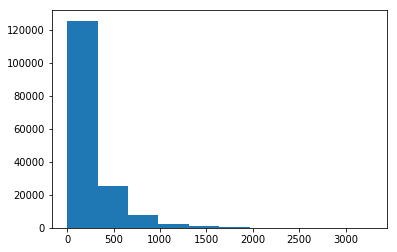

In [121]:
plt.hist(clean_df['ENTRY_DIFFS'].dropna())

In [209]:
# make sure we've removed the high-value outliers
clean_df.sort_values('ENTRY_DIFFS').tail()

,SCP,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,DATETIME,STATION_KEY,ENTRY_DIFFS
177825,00-03-00,NQW,BMT,2018-05-23,12:00:00,REGULAR,37305108,2018-05-23 12:00:00,R512 R092 BROADWAY,2945.0
153236,00-03-03,4567S,IRT,2018-05-22,20:00:00,REGULAR,3981820,2018-05-22 20:00:00,R238 R046 GRD CNTRL-42 ST,2950.0
153289,00-03-04,4567S,IRT,2018-05-24,20:00:00,REGULAR,35056770,2018-05-24 20:00:00,R238 R046 GRD CNTRL-42 ST,3110.0
177831,00-03-00,NQW,BMT,2018-05-24,12:00:00,REGULAR,37313045,2018-05-24 12:00:00,R512 R092 BROADWAY,3184.0
153277,00-03-04,4567S,IRT,2018-05-22,20:00:00,REGULAR,35039938,2018-05-22 20:00:00,R238 R046 GRD CNTRL-42 ST,3279.0


In [100]:
def station_day2(s, d):
    '''Given station key and date,
    returns all entries from original data frame for this station & date'''
    return clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)]

Take the highest-volume stations and look at them more closely

In [127]:
highest_vol = clean_df.sort_values('ENTRY_DIFFS').tail(100)['STATION_KEY'].unique()
len(highest_vol)

14

In [144]:
x_labels = calendar.day_name[5:] + calendar.day_name[:5]

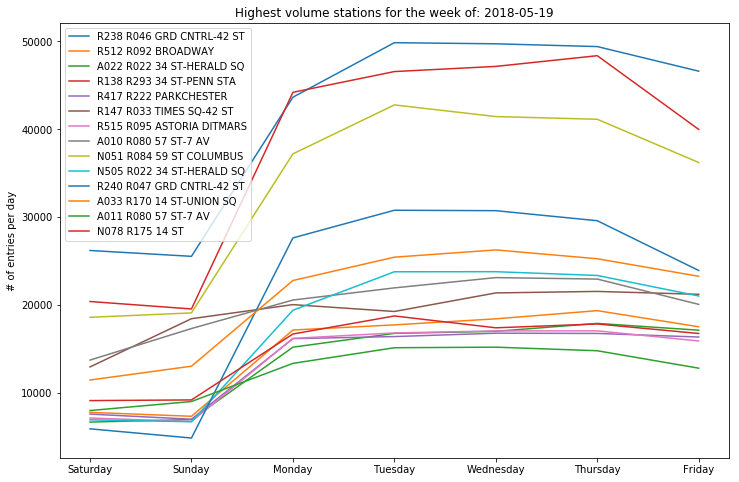

In [207]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    station = highest_vol[0]
    dum_df = grp1[grp1['STATION_KEY'] == s]
    xs = dum_df['DATE']
    week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['ENTRY_DIFFS'], label=s)
    xticklocs = ax.get_xticks()
    plt.xticks(xticklocs, x_labels)
    plt.legend()
    plt.ylabel('# of entries per day')
    plt.title('Highest volume stations for the week of: ' + str(week_start));

**Next steps:** 
- determine what we want our "weekday vs weekend" cut-off to be. 
- plot a heatmap of a few of these stations (GRD CENTRAL, ASTORIA DITMARS, e.g.)